# Navigation MDP [1]

In [1]:
import numpy as np
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
nvmdp = NavigationMDP(width=30, 
                        height=30, 
                        goal_locs=[(21,21)], 
                        init_loc=(1,1), 
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, -10, -10, -10],
                        goal_reward=1.,
                        slip_prob=0.00,
                        step_cost=0.0,
                        vacancy_prob=0.8,
                        gamma=.9999)

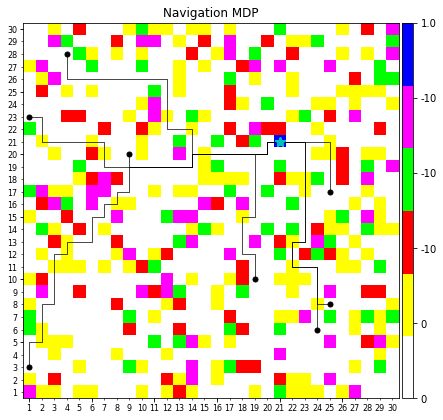

In [3]:
np.random.seed(0)
N_tau = 8
D_traj_states, D_traj_actions = nvmdp.sample_data(n_trajectory=N_tau, init_states=None, init_repetition=False)
nvmdp.visualize_grid(trajectories=D_traj_states, show_rewards_cbar=True)

## Features used for short horizon

In [4]:
[nvmdp.feature_long_at_state(s) for s in D_traj_states[0]]

[array([1., 0., 0., 0., 0., 0., 1., 3., 5., 4.]),
 array([1., 0., 0., 0., 0., 0., 2., 2., 4., 3.]),
 array([1., 0., 0., 0., 0., 0., 1., 3., 5., 4.]),
 array([1., 0., 0., 0., 0., 0., 2., 4., 4., 3.]),
 array([1., 0., 0., 0., 0., 0., 3., 5., 3., 2.]),
 array([1., 0., 0., 0., 0., 0., 2., 6., 2., 1.]),
 array([1., 0., 0., 0., 0., 0., 1., 5., 2., 2.]),
 array([1., 0., 0., 0., 0., 0., 1., 5., 2., 1.]),
 array([0., 1., 0., 0., 0., 1., 0., 4., 2., 2.]),
 array([1., 0., 0., 0., 0., 0., 1., 3., 1., 3.]),
 array([1., 0., 0., 0., 0., 0., 2., 2., 2., 4.]),
 array([1., 0., 0., 0., 0., 0., 2., 1., 2., 3.]),
 array([1., 0., 0., 0., 0., 0., 3., 2., 1., 2.]),
 array([1., 0., 0., 0., 0., 0., 4., 2., 2., 3.]),
 array([1., 0., 0., 0., 0., 0., 4., 1., 1., 2.]),
 array([0., 0., 0., 0., 0., 1., 3., 1., 2., 3.], dtype=float32)]

## Features used for long horizon

In [5]:
[nvmdp.feature_short_at_state(s) for s in D_traj_states[0]]

[array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.], dtype=float32)]

## Reference

[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.